In [1]:
# Needed to import from model directory
import sys
sys.path.insert(0, '../model/')

# Importing the model
import mesa
import mesa_geo as mg
from agents import Person, Neighbourhood, House
from model import Housing

# Other imports
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [2]:
def collect_data(inputs, runs, steps, type):
    """
    Collects data from the model.

    Args:
        inputs (list): The inputs to test.
        runs (int): The number of runs to collect data from.
        steps (int): The number of steps to collect data from.
        type (str): The type of input to test. Can be 'housing', 'population' or 'materialistic'.
    """

    # Create dicts/lists to store results
    results_local_price =       {'Centrum': [],
                                 'Oost': [],
                                 'Nieuw-West': [],
                                 'Zuidoost': [],
                                 'Noord': [],
                                 'West': [],
                                 'Zuid': []}

    results_local_contentment = {'Centrum': [],
                                 'Oost': [],
                                 'Nieuw-West': [],
                                 'Zuidoost': [],
                                 'Noord': [],
                                 'West': [],
                                 'Zuid': []}

    results_global_price, results_global_contentment = [], []
   
    # Collect data for different inputs
    for j, i in enumerate(inputs): 

        # Add empty lists to store results for the current inputs
        results_global_price.append([])
        results_global_contentment.append([])
        for n in results_local_price.keys():
            results_local_price[n].append([])
            results_local_contentment[n].append([])

        # Run the model multiple times
        for r in tqdm(range(runs)):
            
            # Initialise model
            if type == 'housing':
                model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=2, start_money_multiplier_newcomers=2, contentment_threshold=0.75, weight_materialistic=0.5, housing_growth_rate=i, population_growth_rate=1.01)
            elif type == 'population':
                model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=2, start_money_multiplier_newcomers=2, contentment_threshold=0.75, weight_materialistic=0.5, housing_growth_rate=1.01, population_growth_rate=i)
            elif type == 'contentment':
                model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=2, start_money_multiplier_newcomers=2, contentment_threshold=i, weight_materialistic=0.5, housing_growth_rate=1.01, population_growth_rate=1.01)
            elif type == 'materialistic':
                model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=2, start_money_multiplier_newcomers=2, contentment_threshold=0.75, weight_materialistic=i, housing_growth_rate=1.01, population_growth_rate=1.01)
            
            # Run model
            for s in range(steps):
                model.step()

            # Collect neighbourhood data
            neighbourhoods = model.get_agents(Neighbourhood)

            # Save average price and contentment for each neighbourhood
            for n in neighbourhoods:
                results_local_price[n.unique_id][j].append(n.average_house_price)
                results_local_contentment[n.unique_id][j].append(n.average_contentment)

            # Calculate average price and contentment for the whole city
            global_price = np.mean([n.average_house_price for n in neighbourhoods])
            global_contentment = np.mean([n.average_contentment for n in neighbourhoods])

            # Save theses results
            results_global_price[j].append(global_price)
            results_global_contentment[j].append(global_contentment)

    return results_local_price, results_local_contentment, results_global_price, results_global_contentment


In [3]:
def plot_experiments(inputs, results, title, param, method):
    """
    Plots the results of the experiments.

    Args:
        inputs (list): The inputs to test.
        results (dict): The results to plot.
        title (str): The title of the plot.
        param (str): The parameter that was tested.
        method (str): The method that was tested.
    """

    # Average Price Plot
    if method == 'price':
        for n, result in results.items():

            # Reset plot lists
            x, y = [], []

            # Create lists of x and y values
            for i, r in zip(inputs, result):
                x = x + [i] * len(r)
                y = y + r

            # Plot results
            plt.scatter(x, y, s=5, marker='<', label=n, alpha=0.2)

        # Set y-axis label
        plt.ylabel('Average House Price')

    # Average Contentment Plot
    elif method == 'contentment':
        for n, result in results.items():

            # Reset plot lists
            x, mean, variance, std_dev, confidence = [], [], [], [], []

            # Calculate stats of a particular input value for a neighbourhood
            for i, r in zip(inputs, range(len(result[0]))):
                x = x + [i]
                data = [result[r][j] for j in range(len(result[0]))]
                mean.append(np.mean(data))
                variance.append(np.var(data))
                std_dev.append(np.sqrt(np.var(data)))
                confidence.append(st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data)))

            # Plot results
            plt.plot(x, mean, alpha=0.8, label=n)
            plt.fill_between(x, [c[0] for c in confidence], [c[1] for c in confidence], alpha=0.2)
            # plt.fill_between(x, np.array(mean)-np.array(std_dev), np.array(mean)+np.array(std_dev), label=n, alpha=0.2) # Standard Deviation

        # Set y-axis label
        plt.ylabel('Average Contentment')

    # Set x-axis labels
    if param == 'housing': plt.xlabel('Housing Growth Rate')
    elif param == 'population': plt.xlabel('Population Growth Rate')
    elif param == 'contentment': plt.xlabel('Contentment Threshold')
    elif param == 'materialistic': plt.xlabel('Materialistic Weight')
    
    # Set title
    plt.title(title)

    plt.legend()
    plt.show()


## Experiment 1:

**RQ: What is the influence of an increase of avalible housing on the average house price and contentment of Amsterdam?**

Vary the Housing Growth Rate from 1.0 to 1.1 and compare the output in average contentment and house price per neighbourhood. The other parameters will be initialized by their default values. 

In [8]:
# Define input range for Housing Growth Rate 
inputs = np.linspace(1.0, 1.1, 11)
# Define number of runs and steps
runs, steps = 50, 10

# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(inputs, runs, steps, 'housing')

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]


KeyboardInterrupt: 

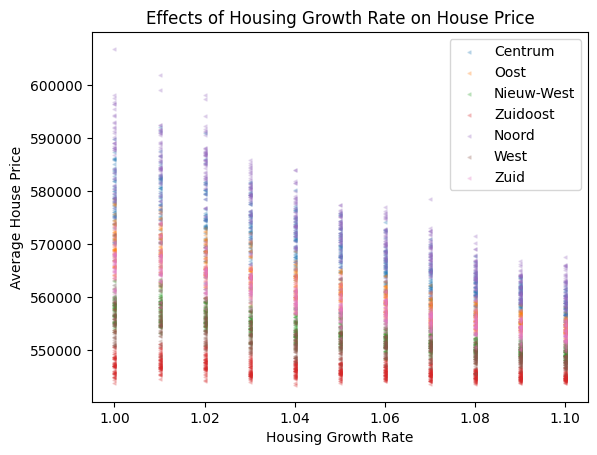

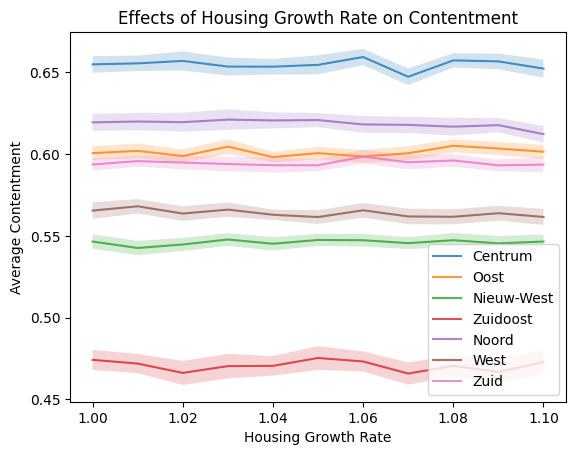

In [ ]:
# Plot results
plot_experiments(inputs, results_local_price, 'Effects of Housing Growth Rate on House Price', 'housing', 'price')
plot_experiments(inputs, results_local_contentment, 'Effects of Housing Growth Rate on Contentment', 'housing', 'contentment')

## Experiment 2:

**RQ: What is the influence of an increase of demand on the average house price and contentment of Amsterdam?**

Vary the Population Growth Rate from 1.0 to 1.1 and compare the output in average contentment and house price per neighbourhood. The other parameters will be initialized by their default values. 

In [ ]:
# Define input range for Population Growth Rate 
inputs = np.linspace(1.0, 1.1, 11)
# Define number of runs and steps
runs, steps = 50, 10

# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(inputs, runs, steps, 'population')

100%|██████████| 50/50 [05:47<00:00,  6.94s/it]


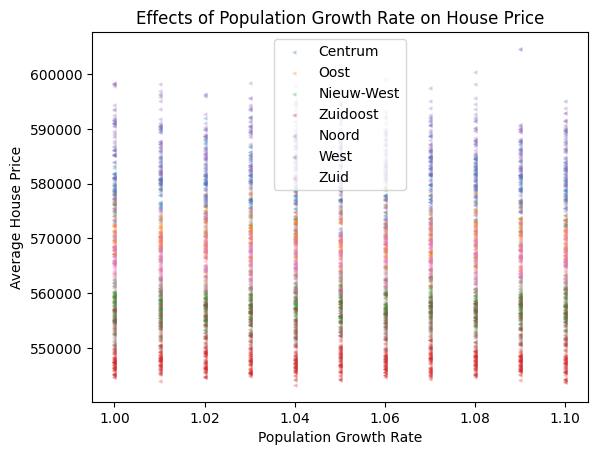

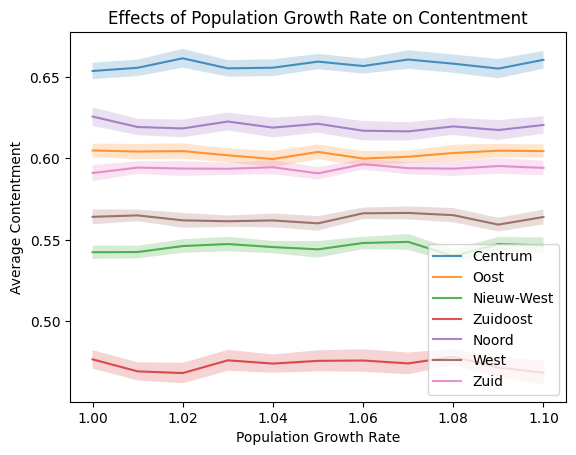

In [ ]:
# Plot results
plot_experiments(inputs, results_local_price, 'Effects of Population Growth Rate on House Price', 'population', 'price')
plot_experiments(inputs, results_local_contentment, 'Effects of Population Growth Rate on Contentment', 'population', 'contentment')

## Experiment 3:

**RQ: What is the influence of societal standards on the average house price and contentment of Amsterdam?**

Vary the Contentment Threshold from 0.0 to 1.0 and compare the output in average contentment and house price per neighbourhood. The other parameters will be initialized by their default values. 

In [4]:
# Define input range for Contentment Threshold
inputs = np.linspace(0.0, 2.0, 11)
# Define number of runs and steps
runs, steps = 50, 10

# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(inputs, runs, steps, 'contentment')

100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


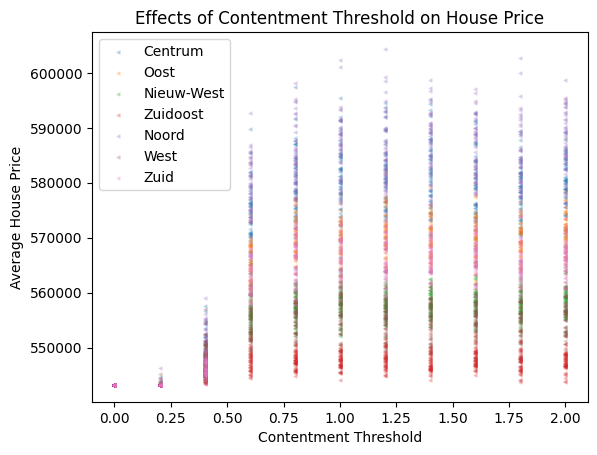

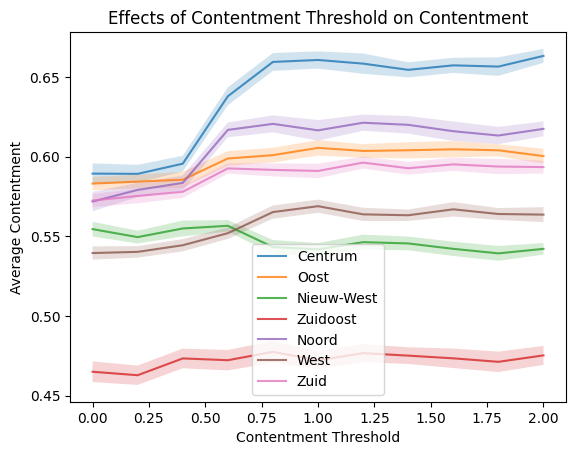

In [5]:
# Plot results
plot_experiments(inputs, results_local_price, 'Effects of Contentment Threshold on House Price', 'contentment', 'price')
plot_experiments(inputs, results_local_contentment, 'Effects of Contentment Threshold on Contentment', 'contentment', 'contentment')

## Experiment 4:

**RQ: What is the influence of an increase of avalible housing on the average house price of Amsterdam?**

Vary the Weigth Materialisic from 0 to 1 and compare the output in average contentment and house price per neighbourhood. The other parameters will be initialized by their default values. 

In [12]:
# Define input range for Weight Materialistic
inputs = np.linspace(0.0, 1.0, 11)
# Define number of runs and steps
runs, steps = 50, 10

# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(inputs, runs, steps, 'materialistic')

100%|██████████| 50/50 [04:56<00:00,  5.94s/it]


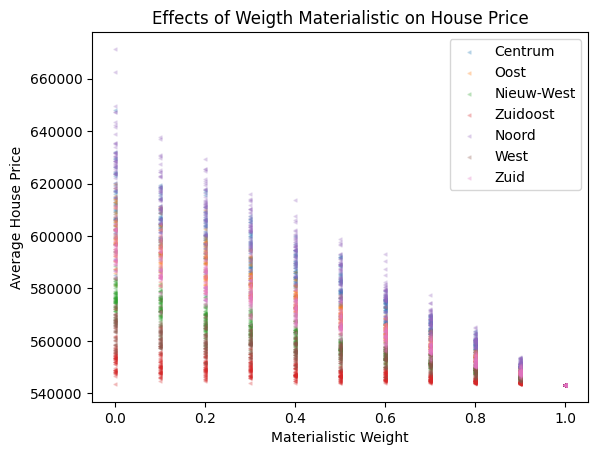

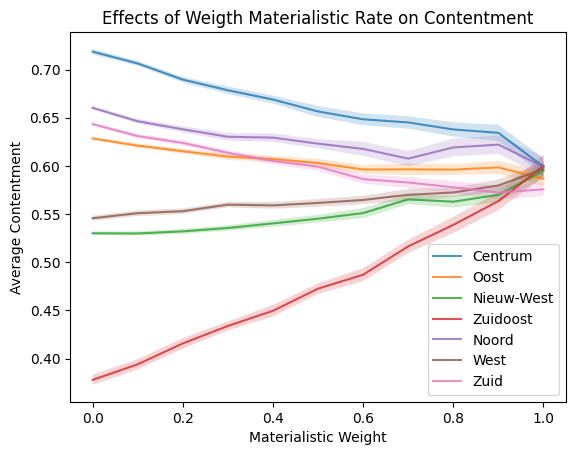

In [13]:
# Plot results
plot_experiments(inputs, results_local_price, 'Effects of Weigth Materialistic on House Price', 'materialistic', 'price')
plot_experiments(inputs, results_local_contentment, 'Effects of Weigth Materialistic Rate on Contentment', 'materialistic', 'contentment')

## Baseline:

Get model output with baseline params.

In [5]:
# Define number of runs and steps
runs, steps = 550, 10

# Create dicts/lists to store results
# results_local_price =       {'Centrum': [],
#                                 'Oost': [],
#                                 'Nieuw-West': [],
#                                 'Zuidoost': [],
#                                 'Noord': [],
#                                 'West': [],
#                                 'Zuid': []}

# results_local_contentment = {'Centrum': [],
#                                 'Oost': [],
#                                 'Nieuw-West': [],
#                                 'Zuidoost': [],
#                                 'Noord': [],
#                                 'West': [],
#                                 'Zuid': []}

results_global_price, results_global_contentment = [], []

# Run the model multiple times
for r in tqdm(range(runs)):
    # Initialize model
    model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=2, start_money_multiplier_newcomers=2, contentment_threshold=0.75, weight_materialistic=0.5, housing_growth_rate=1.01, population_growth_rate=1.01)
    
    # Run model
    for s in range(steps):
        model.step()

    # Collect neighbourhood data
    neighbourhoods = model.get_agents(Neighbourhood)

    # # Save average price and contentment for each neighbourhood
    # for n in neighbourhoods:
    #     results_local_price[n.unique_id].append(n.average_house_price)
    #     results_local_contentment[n.unique_id].append(n.average_contentment)

    # Calculate average price and contentment for the whole city
    global_price = np.mean([n.average_house_price for n in neighbourhoods])
    global_contentment = np.mean([n.average_contentment for n in neighbourhoods])

    # Save theses results
    results_global_price.append(global_price)
    results_global_contentment.append(global_contentment)


100%|██████████| 550/550 [23:15<00:00,  2.54s/it]


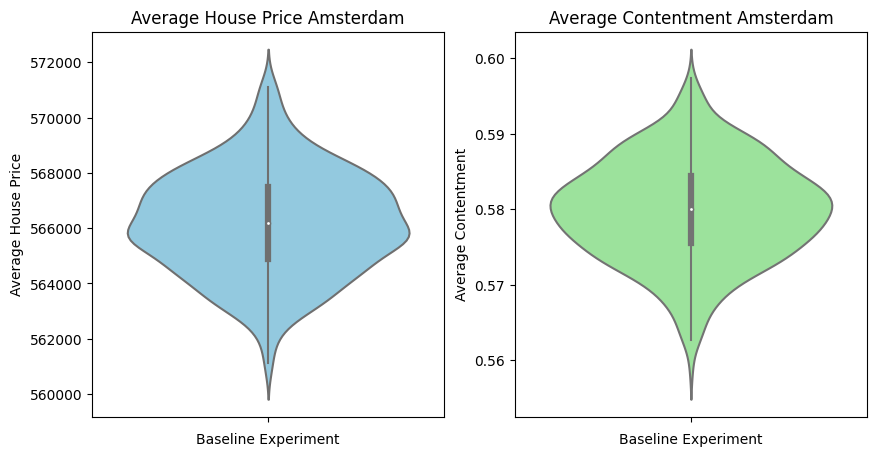

In [16]:
# Create the figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first violin plot
sns.violinplot(data=results_global_price, ax=ax[0], color="skyblue")
# sns.stripplot(data=results_global_price, ax=ax[0], color="red", jitter=0.2)
ax[0].set_title("Average House Price Amsterdam")
ax[0].set_xticklabels([])
ax[0].set_ylabel("Average House Price")
ax[0].set_xlabel("Baseline Experiment")

# Plot the second violin plot
sns.violinplot(data=results_global_contentment, ax=ax[1], color="lightgreen")
# sns.stripplot(data=results_global_contentment, ax=ax[1], color="red", jitter=0.3)
ax[1].set_title("Average Contentment Amsterdam")
ax[1].set_xticklabels([])
ax[1].set_ylabel("Average Contentment")
ax[1].set_xlabel("Baseline Experiment")

# Show the plot
plt.show()